In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
import warnings

C:\Users\AIsma\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
warnings.filterwarnings("ignore")

In [3]:
cal = pd.read_csv("calendar.csv")
sales_tv = pd.read_csv("sales_train_validation.csv")
sales_te = pd.read_csv("sales_train_evaluation.csv")
samp_sub = pd.read_csv("sample_submission.csv")
prices = pd.read_csv("sell_prices.csv")

In [ ]:
# samp_submission = samp_sub.T
# samp_submission = samp_submission.set_axis(samp_submission.iloc[0,:], axis="columns").drop("id", axis = 0)

In [4]:
# A bit of preprocessing and df transformation

# Dropping some columns and transposing the table to time series format
sales_te_long = sales_te.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1).T 
sales_te_long = sales_te_long.set_axis(sales_te_long.iloc[0,:], axis="columns").drop(["id"], axis=0)

sales_tv_long = sales_tv.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1).T 
sales_tv_long = sales_tv_long.set_axis(sales_tv_long.iloc[0,:], axis="columns").drop(["id"], axis=0)

# Joining two tables with sales data into one table

#sales = sales_te_long.join(sales_tv_long)

# Setting the index of Calendar dataset to match sales dataset
cal.set_index("d", inplace = True)

# joining two dataset by index
sales_long = sales_te_long.join(cal, how="left")

# Dropping columns with "snap" by state 
sales_long = sales_long.drop(["event_name_1", "event_type_1", "event_type_2", "event_name_2",
                               "snap_CA", "snap_TX", "snap_WI",
                               "wm_yr_wk", "weekday", "wday", "month", "year"], axis=1)

# Setting index as date
sales_long.set_index("date", inplace = True)
sales_long.index = pd.to_datetime(sales_long.index)

In [5]:
forecast_dates = pd.date_range("2016-05-23","2016-06-19", freq = "D")
future_df = pd.DataFrame(index = forecast_dates)
sales_long = pd.concat([sales_long, future_df]).fillna(0)

In [6]:
sales_long

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Processing of events calendar to get dummies on each type
events = cal[["date","event_type_1", "snap_CA", "snap_TX", "snap_WI"]]
events.set_index("date", inplace = True)
events.index = pd.to_datetime(events.index)
events = pd.get_dummies(events, prefix="event", dtype = int)

In [8]:
def create_features(dataframe):
    
    """
    Creating time series features based on date to shift the problem to ML plane
    """
    dataframe = dataframe.copy()
    dataframe['dayofweek'] = dataframe.index.dayofweek
    dataframe['quarter'] = dataframe.index.quarter
    dataframe['month'] = dataframe.index.month
    dataframe['year'] = dataframe.index.year
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['dayofmonth'] = dataframe.index.day
    dataframe['weekofyear'] = dataframe.index.isocalendar().week
    dataframe['weekofyear'] = dataframe['weekofyear'].astype(int)
    
    
    """
    Creating event-specific features
    """
    dataframe = dataframe.join(events)
    
    
    """
    Creating moving average features 
    """
    #dataframe["rolling_mean_7"] = dataframe.iloc[:,0].rolling(7).mean().astype(float)
    #dataframe["rolling_mean_30"] = dataframe.iloc[:,0].rolling(30).mean().astype(float)
    
    
    """
    Introducing lag features 
    """
    dataframe["lag1"] = dataframe.iloc[:,0].shift(1).astype(float)
    dataframe["lag7"] = dataframe.iloc[:,0].shift(7).astype(float)
    dataframe["lag_1y"] = dataframe.iloc[:,0].shift(365).astype(float)
    dataframe["lag_2y"] = dataframe.iloc[:,0].shift(730).astype(float)
    dataframe["lag_3y"] = dataframe.iloc[:,0].shift(730).astype(float)
    
    
    return dataframe

In [29]:
# Creatind DataFrame to store predictions
eval_forecast_dates = pd.date_range("2016-05-23","2016-06-19", freq = "D")
valid_forecast_dates = pd.date_range("2016-05-23","2016-06-19", freq = "D")
valid_preds = pd.DataFrame(index = forecast_dates)
eval_preds = pd.DataFrame(index = eval_forecast_dates)

In [30]:
UNITS_IDs = sales_long.columns

for unit in tqdm(range(len(UNITS_IDs))):
    
    # Extracting particular time series for analysis in the for of DataFrame
    unit_sales = pd.DataFrame(index = sales_long.index,
                              data = sales_long[UNITS_IDs[unit]])

    # Creating features
    unit_sales = create_features(unit_sales)
    
    # Splitting the data    
    
    # Creating a features list containing all columns labels except for target   
    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
            "snap_CA", "snap_TX", "snap_WI",
            "event_Cultural", "event_National", "event_Religious", "event_Sporting",
            #"rolling_mean_7", "rolling_mean_30",
            "lag1", "lag7", "lag_1y", "lag_2y", "lag_3y"]
    
    TARGET = UNITS_IDs[unit]
    
    X_train = unit_sales[:"2016-04-24"][FEATURES]
    y_train = unit_sales[:"2016-04-24"][TARGET]
    
    X_valid = unit_sales["2016-04-25":"2016-05-22"][FEATURES]
    y_valid = unit_sales["2016-04-25":"2016-05-22"][TARGET]
    
    X_test = unit_sales["2016-05-23":][FEATURES]
    
    # Defining a model
    reg = xgb.XGBRegressor(n_estimators=500,
                           learning_rate=0.01)
    
    # Fitting a model
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=False,
            eval_metric='rmse')
    
    
    valid_preds[UNITS_IDs[unit]] = reg.predict(X_valid)
    eval_preds[UNITS_IDs[unit]] = reg.predict(X_test)

100%|██████████| 30490/30490 [5:09:35<00:00,  1.64it/s]  


In [31]:
valid_preds.to_csv("valid_preds.csv", index=True)
eval_preds.to_csv("eval_preds.csv", index=True)

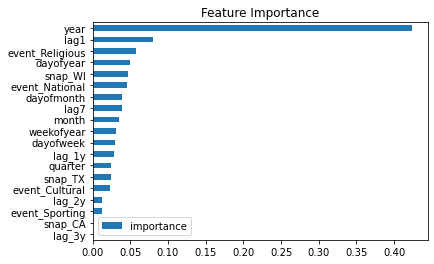

In [32]:
# Feature importance analysis
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index = FEATURES,
                                  columns=['importance'])

feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [153]:
# # Dividing the data into train and test sample with TimeSeriesSplit

# tss = TimeSeriesSplit(n_splits = 5, test_size=365*1)

# fold = 0
# preds = []
# scores = []

# for train_idx, test_idx in tqdm(tss.split(good_series)):
    
#     # Slicing into train and test splits with cross-validation 
#     train = good_series.iloc[train_idx]
#     test = good_series.iloc[test_idx]
    
#     # Creating features for train and test samples
#     good_series_ft_train = create_features(train)
#     good_series_ft_test = create_features(test)
    
#     # Creating a features list containing all columns labels except for target   
#     FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
#             "snap_CA", "snap_TX", "snap_WI",
#             "event_Cultural", "event_National", "event_Religious", "event_Sporting",
#                "lag1", "lag7", "lag365"]
#     TARGET = commodities[0]
    
#     # Defining design matrix and target vector
#     X_train = good_series_ft_train[FEATURES]
#     y_train = good_series_ft_train[TARGET]

#     X_test = good_series_ft_test[FEATURES]
#     y_test = good_series_ft_test[TARGET]
    
#     # Defining a model
#     reg = xgb.XGBRegressor(n_estimators=700,
#                            early_stopping_rounds=50,
#                            objective='reg:linear',
#                            learning_rate=0.001)
    
#     # Fitting a model
#     reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)
    
#     y_pred = reg.predict(X_test)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)

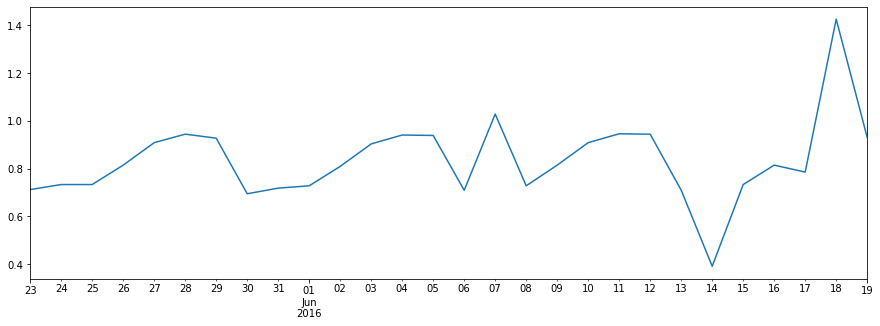

In [278]:
# future_w_features["preds"].plot(figsize = (15,5))
# plt.show()

In [11]:
# for column in tqdm(range(len(sales_te_long.columns))):
#     #print(sales_te_long.columns[column])
#     sales_te_long[sales_te_long.columns[column]] = sales_te_long[sales_te_long.columns[column]].astype(float)

In [10]:
# Processed_file = sales_te_long.T
# Processed_file.to_excel("sales_te_long.xlsx")